<a href="https://colab.research.google.com/github/harrisonp1223/CongressionalAnalytics/blob/main/GSB_521_Project_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Greg Larmour
glarmour@calpoly.edu
# Harrison Pearce
hlpearce@calpoly.edu


GSB 521 - Pierce

8 February 2023

# Questions For Analysis:

1. Are Democrats Or Republicans Better Investors?

Intitial Hypothesis: Democrats and Republicans, on average, are equally profitable Investors.

2. Did Democrats or Republicans Receive More COVID Unemployment Funding?

Intitial Hypothesis: Democrats and Republicans, on average, received an equal amount of unemployment funding during COVID.

In [2]:
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt

We will first collect data from the census on household incomes for every congressional district in each state. 

In [3]:
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"
response = urlopen(url)
data_json = json.loads(response.read())
data_json.pop(0) 
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']
acs_df = pd.DataFrame(data_json, columns = cols)
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])
acs_df['State'] = acs_df['State'].str.strip()
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

We will clean our congressional income data below.

In [4]:
party_df = pd.read_csv("http://goodcsv.com/wp-content/uploads/2020/08/us-house-of-representatives-2020.csv", encoding = "ISO-8859-1")
party_df['district number'] = party_df['District/Position'].str.extract('(\d+)')
party_df['district number'] = party_df['district number'].fillna(0)
party_df['district number'] = pd.to_numeric(party_df['district number'])
party_df['State'] = party_df['State/Territory']
party_df['State'] = party_df['State'].str.strip()
party_df['Party'] = party_df['Party'].str.strip() 
party_df = party_df[['State', 'Party', "district number"]]

In [5]:
merged_df = pd.merge(acs_df, party_df, on=["State", "district number"])

We will now import our data from the Internal Revenue Service. The dataset from the Internal Revenue Service includes many interesting variables about the characteristics of each Congressional District. These include metrics such as gross income, total income, taxed income, number of returns, amounts of returns, along with many other variables. This Data Set includes information about the year 2020.


We would like to further explore the total capital gain (or loss) in each district in order to characterize the investing performance of congressional parties with differing political designations. 


We would then like to analyze the total unemployment compensation recieved per district in 2020, the COVID year where many Americans recieved unemployment checks due to their untimely unemployment. 

Finally, we will use the IRS Dataset to analyze the relationships between the variables of interest listed above with each district's total income. 

In [6]:
social_df = pd.read_csv("https://www.irs.gov/pub/irs-soi/20incd.csv")

Our data needs to be cleaned so we can merge it with our political party data set and our congressional income data set. This is done below by converting each State abbreviation to the state's full name.

In [7]:

state_abbr_to_name = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 
                     'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 
                     'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 
                     'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                     'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 
                     'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
                     'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 
                     'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 
                     'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                     'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                     'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 
                     'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 
                     'WI': 'Wisconsin', 'WY': 'Wyoming'}
social_df['State'] = social_df['STATE'].map(state_abbr_to_name)
social_df['district number'] = social_df['CONG_DISTRICT']

In [8]:
merged_df_final = pd.merge(merged_df, social_df, on=["State", "district number"])                           
merged_df_final['Number of Farm Returns']  = merged_df_final["SCHF"]
merged_df_final['Net Capital Gain (Or Loss)']  = merged_df_final["A01000"]
merged_df_final["COVID Unemployment Compensation Amount"] = merged_df_final["A02300"]
merged_df_final['Total Income'] = merged_df_final['A02650']

In [ ]:
print(merged_df_final.describe)

In [21]:
merged_df_final['CONG_DISTRICT'] = merged_df_final['State'] + "_" + merged_df_final['CONG_DISTRICT'].astype(str)

agg_data = merged_df_final.groupby(['CONG_DISTRICT']).agg({'Total Income': 'sum', 
                                                           'COVID Unemployment Compensation Amount': 'sum', 
                                                           'Net Capital Gain (Or Loss)': 'sum', "Party": "first"})
print(agg_data)

                                 Total Income  \
CONG_DISTRICT                                   
Alabama_Alabama_Alabama_1          39181962.0   
Alabama_Alabama_Alabama_2          32908028.0   
Alabama_Alabama_Alabama_3          34751480.0   
Alabama_Alabama_Alabama_4          32606990.0   
Alabama_Alabama_Alabama_5          51375902.0   
...                                       ...   
Wisconsin_Wisconsin_Wisconsin_5    65973130.0   
Wisconsin_Wisconsin_Wisconsin_6    52907258.0   
Wisconsin_Wisconsin_Wisconsin_7    46738266.0   
Wisconsin_Wisconsin_Wisconsin_8    54259170.0   
Wyoming_Wyoming_Wyoming_0          51268314.0   

                                 COVID Unemployment Compensation Amount  \
CONG_DISTRICT                                                             
Alabama_Alabama_Alabama_1                                      986096.0   
Alabama_Alabama_Alabama_2                                      717290.0   
Alabama_Alabama_Alabama_3                                     

# PLOT 1 :

Net Capital Gain (Or Loss) Per District vs. Total District Income

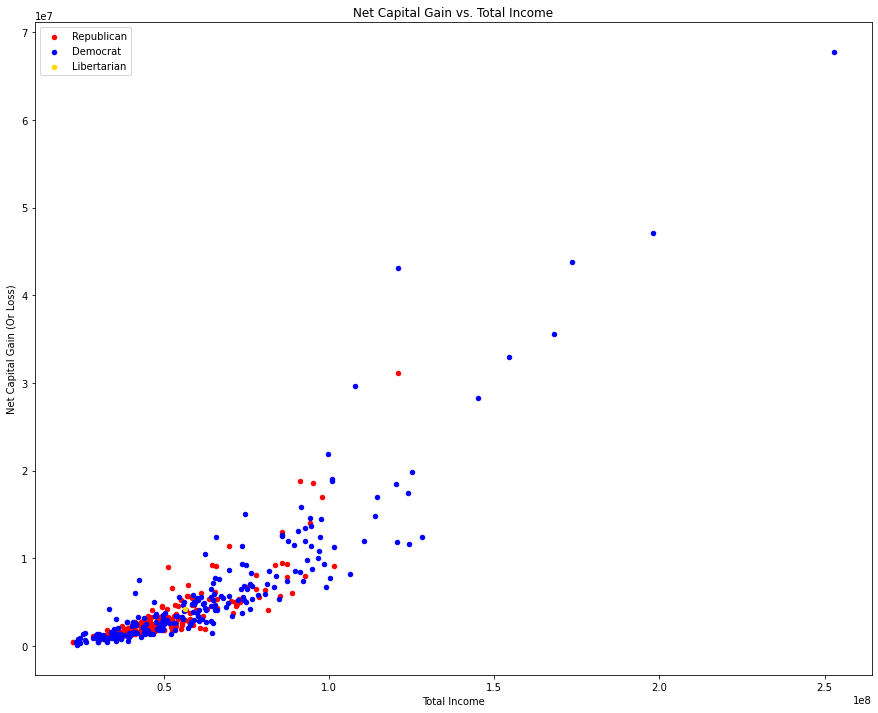

In [22]:
R = agg_data[agg_data['Party'].str.contains('R')]
D = agg_data[agg_data['Party'].str.contains('D')]
L = agg_data[agg_data['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)', c='red',label='Republican', ax=ax, title = 'Net Capital Gain vs. Total Income')
D.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)',c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Total Income', y='Net Capital Gain (Or Loss)',c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

# Analysis of 1st Hypothesis:

As income increases, Net Capital Gain in each district exponentially increases. This is especially shown in Democratic districts. On average, it appears that for larger income areas, Capital Gains from investments are larger as well. Comparing the Democratic and Republican districts, we can see that they both follow a similar distribution but there are many more Democratic districts in the high income & high net capital gain portion of the graph. This indicates that Democrats would on average slightly beat Republicans in investment performance. 

# PLOT 2 :

COVID Unemployment Compensation Amount ($) vs. Total District Income

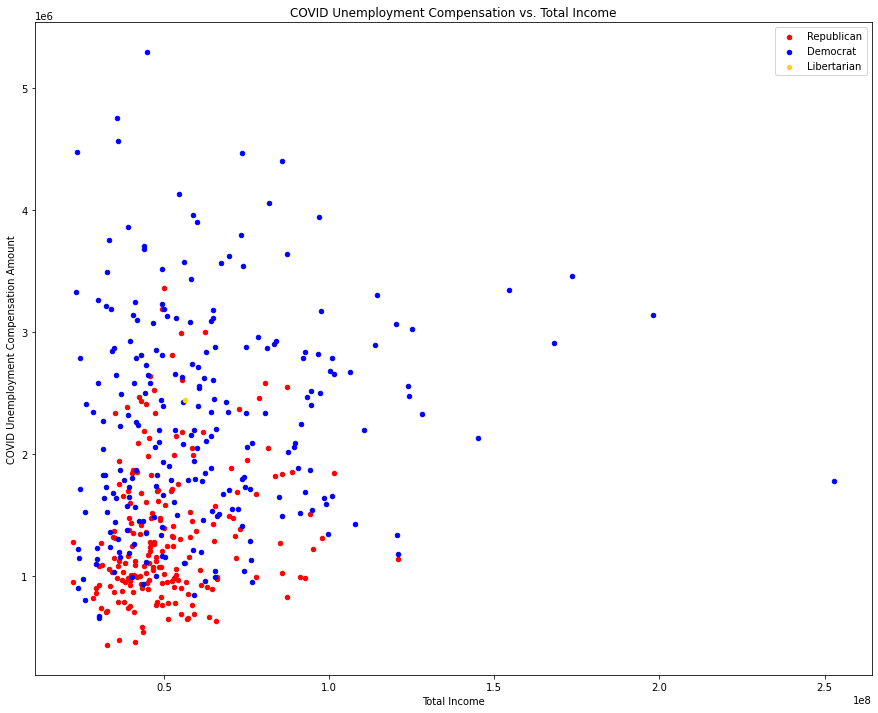

In [23]:
R = agg_data[agg_data['Party'].str.contains('R')]
D = agg_data[agg_data['Party'].str.contains('D')]
L = agg_data[agg_data['Party'].str.contains('L')]

fig, ax = plt.subplots(figsize=(15, 12))
R.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount", c='red',label='Republican', ax=ax,  title = 'COVID Unemployment Compensation vs. Total Income')
D.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount",c='blue',label='Democrat', ax=ax)
L.plot.scatter(x='Total Income', y="COVID Unemployment Compensation Amount",c='gold',label='Libertarian', ax=ax)

plt.legend()
plt.show()

# Analysis of 2nd Hypothesis:

Interestingly enough, as Total District income increased, the amount of COVID unemployment compensation also increased. This Unemployment Compensation was greater in Low income areas for Democratic districts. The compensation was also greater in High income areas for Democratic districts. In Plot 2 we can observe a positive correlation between Total Income and Unemployment Benefits amongst Democratic districts, along with low-income Democratic districts having extremely high unemployment benefits relative to Republican districts. 

# Conclusion:

We initially predicted that Democrats and Republicans were equally profitable investors, and that Democrats and Republicans would receive the same amount of unemployment benefits on average. After further analysis, we reject our initial hypotheses with evidence from our congressional district data and conclude that Democrats are more profitable investors than Republicans on average, and that Democrats generally received more unemployment benefits than Republicans on average. 

In [2]:
import csv

data = [["NAME","B19001_001E","B19001_002E","B19001_017E","state","congressional district"],
["Congressional District 10 (116th Congress), Michigan","289474","14153","19390","26","10"],
["Congressional District 4 (116th Congress), Mississippi","299804","23793","10899","28","04"],
["Congressional District 14 (116th Congress), Michigan","278057","27728","19574","26","14"],
["Congressional District 1 (116th Congress), Michigan","306685","19036","12208","26","01"],
["Congressional District 3 (116th Congress), Mississippi","285554","26481","12412","28","03"],
["Congressional District 4 (116th Congress), Nevada","283677","18570","17797","32","04"],
["Congressional District 3 (116th Congress), Nevada","343373","20441","38494","32","03"],
["Congressional District 2 (116th Congress), New Hampshire","262930","9151","29470","33","02"],
["Congressional District 1 (116th Congress), New Hampshire","285096","8084","32668","33","01"],
["Congressional District 1 (116th Congress), Nebraska","263104","12087","15711","31","01"],
["Congressional District 3 (116th Congress), New Mexico","271782","23084","16799","35","03"],
["Congressional District 1 (116th Congress), Ohio","308009","24164","30709","39","01"],
["Congressional District 5 (116th Congress), Oklahoma","333919","23520","20966","40","05"],
["Congressional District 9 (116th Congress), North Carolina","289178","19460","33817","37","09"],
["Congressional District 10 (116th Congress), North Carolina","314682","18235","16908","37","10"],
["Congressional District 8 (116th Congress), New York","305027","30603","30808","36","08"],
["Congressional District 9 (116th Congress), New York","299573","25957","34095","36","09"],
["Congressional District 10 (116th Congress), New York","316752","22546","78661","36","10"],
["Congressional District 11 (116th Congress), New York","268455","19149","31124","36","11"],
["Congressional District 13 (116th Congress), New York","297240","40571","17943","36","13"],
["Congressional District 16 (116th Congress), New York","284253","20517","51951","36","16"],
["Congressional District 17 (116th Congress), New York","258942","10689","63437","36","17"],
["Congressional District 3 (116th Congress), Pennsylvania","335449","41413","27360","42","03"],
["Congressional District 1 (116th Congress), Rhode Island","220794","14673","21154","44","01"],
["Congressional District 5 (116th Congress), Oregon","325468","15085","29661","41","05"],
["Congressional District 20 (116th Congress), New York","314476","18247","28446","36","20"],
["Congressional District 3 (116th Congress), New Jersey","293063","12956","39369","34","03"],
["Congressional District 5 (116th Congress), New Jersey","275729","9737","64915","34","05"],
["Congressional District 7 (116th Congress), New Jersey","286558","7946","81477","34","07"],
["Congressional District 9 (116th Congress), New Jersey","283783","17923","36065","34","09"],
["Congressional District 1 (116th Congress), New Jersey","290002","15161","30468","34","01"],
["Congressional District 2 (116th Congress), Ohio","309474","21918","24953","39","02"],
["Congressional District 4 (116th Congress), Ohio","284441","16750","12465","39","04"],
["Congressional District 6 (116th Congress), Ohio","273565","22649","9621","39","06"],
["Congressional District 8 (116th Congress), Ohio","292024","15971","16907","39","08"],
["Congressional District 10 (116th Congress), Ohio","304802","20645","17535","39","10"],
["Congressional District 12 (116th Congress), Ohio","318732","14577","38734","39","12"],
["Congressional District 15 (116th Congress), Ohio","303591","14183","24550","39","15"],
["Congressional District 6 (116th Congress), Pennsylvania","286271","12485","49578","42","06"],
["Congressional District 3 (116th Congress), Oregon","349398","19624","38036","41","03"],
["Congressional District 23 (116th Congress), New York","289341","21779","13771","36","23"],
["Congressional District 1 (116th Congress), Oregon","343553","14195","45888","41","01"],
["Congressional District 2 (116th Congress), Oregon","342608","20428","21665","41","02"],
["Congressional District 27 (116th Congress), New York","300622","12945","22902","36","27"],
["Congressional District 8 (116th Congress), Pennsylvania","285970","16480","13516","42","08"],
["Congressional District 10 (116th Congress), Pennsylvania","307667","14682","20361","42","10"],
["Congressional District 13 (116th Congress), Pennsylvania","278024","13984","11267","42","13"],
["Congressional District 15 (116th Congress), Pennsylvania","270163","15420","8943","42","15"],
["Congressional District 17 (116th Congress), Pennsylvania","312461","13046","35588","42","17"],
["Congressional District 2 (116th Congress), Tennessee","319491","16789","20480","47","02"],
["Congressional District 9 (116th Congress), Tennessee","279504","29850","9652","47","09"],
["Congressional District 5 (116th Congress), Tennessee","348817","23202","31198","47","05"],
["Congressional District 6 (116th Congress), Tennessee","322047","18630","14769","47","06"],
["Congressional District 7 (116th Congress), Tennessee","312762","15464","30771","47","07"],
["Congressional District 6 (116th Congress), South Carolina","257478","31656","9172","45","06"],
["Congressional District 3 (116th Congress), South Carolina","279642","18726","11105","45","03"],
["Congressional District 1 (116th Congress), Utah","267358","12789","25776","49","01"],
["Congressional District (at Large) (116th Congress), South Dakota","356887","17158","20292","46","00"],
["Congressional District 8 (116th Congress), Texas","334410","18661","45728","48","08"],
["Congressional District 9 (116th Congress), Texas","288665","25143","9156","48","09"],
["Congressional District 8 (116th Congress), Virginia","324687","13261","81900","51","08"],
["Congressional District 9 (116th Congress), Virginia","284060","26006","8057","51","09"],
["Congressional District 10 (116th Congress), Virginia","300190","6631","93838","51","10"],
["Congressional District 1 (116th Congress), Virginia","297988","11861","45205","51","01"],
["Congressional District 7 (116th Congress), Washington","373393","18604","94098","53","07"],
["Congressional District 8 (116th Congress), Washington","284410","10080","53806","53","08"],
["Congressional District 9 (116th Congress), Washington","296031","15217","57319","53","09"],
["Congressional District 1 (116th Congress), Washington","298959","10706","71479","53","01"],
["Congressional District 5 (116th Congress), Washington","301159","17383","17101","53","05"],
["Congressional District 21 (116th Congress), Texas","372831","19725","48193","48","21"],
["Congressional District 23 (116th Congress), Texas","285043","16412","20253","48","23"],
["Congressional District 25 (116th Congress), Texas","322257","14827","45578","48","25"],
["Congressional District 27 (116th Congress), Texas","284443","19082","15221","48","27"],
["Congressional District 29 (116th Congress), Texas","227558","16605","5531","48","29"],
["Congressional District 30 (116th Congress), Texas","286752","22523","11614","48","30"],
["Congressional District 32 (116th Congress), Texas","305599","17093","46374","48","32"],
["Congressional District 33 (116th Congress), Texas","236861","18353","6457","48","33"],
["Congressional District 35 (116th Congress), Texas","317342","24389","13808","48","35"],
["Congressional District 1 (116th Congress), Texas","264420","18491","13794","48","01"],
["Congressional District 3 (116th Congress), Wisconsin","296985","14460","12804","55","03"],
["Congressional District 1 (116th Congress), South Carolina","324758","17028","33813","45","01"],
["Congressional District 5 (116th Congress), Wisconsin","310413","11268","29305","55","05"],
["Congressional District 1 (116th Congress), Wisconsin","291574","12386","23004","55","01"],
["Congressional District (at Large) (116th Congress), Wyoming","242763","14659","14179","56","00"],
["Congressional District (at Large) (116th Congress), Alaska","271311","14625","27700","02","00"],
["Congressional District 2 (116th Congress), Connecticut","282851","12379","33043","09","02"],
["Congressional District 2 (116th Congress), Alabama","267988","22053","10659","01","02"],
["Congressional District 7 (116th Congress), Alabama","265421","29736","8180","01","07"],
["Congressional District 4 (116th Congress), Connecticut","278120","14613","71746","09","04"],
["Congressional District 4 (116th Congress), Alabama","265042","19087","10066","01","04"],
["Congressional District 5 (116th Congress), Connecticut","286232","14241","41239","09","05"],
["Congressional District 5 (116th Congress), Alabama","312227","18511","24457","01","05"],
["Congressional District 1 (116th Congress), Connecticut","291567","16156","31953","09","01"],
["Congressional District 6 (116th Congress), Alabama","283340","14339","26705","01","06"],
["Congressional District 3 (116th Congress), Connecticut","289543","17184","30214","09","03"],
["Congressional District 1 (116th Congress), Alabama","287768","22411","12033","01","01"],
["Congressional District 3 (116th Congress), Alabama","285773","26313","9731","01","03"],
["Congressional District 4 (116th Congress), Arkansas","267232","21896","7245","05","04"],
["Congressional District 3 (116th Congress), Arkansas","323384","18617","22106","05","03"],
["Congressional District 2 (116th Congress), Arizona","321286","20104","19549","04","02"],
["Congressional District 4 (116th Congress), California","303443","11957","49244","06","04"],
["Congressional District 5 (116th Congress), California","269118","13751","36997","06","05"],
["Congressional District 6 (116th Congress), California","294556","18836","24112","06","06"],
["Congressional District 8 (116th Congress), California","246866","14106","14245","06","08"],
["Congressional District 9 (116th Congress), California","250217","12288","29533","06","09"],
["Congressional District (at Large) (116th Congress), Delaware","395656","20504","33025","10","00"],
["Congressional District 11 (116th Congress), California","276718","12712","66864","06","11"],
["Congressional District 13 (116th Congress), California","295012","16375","62158","06","13"],
["Congressional District 3 (116th Congress), Arizona","262352","19475","9024","04","03"],
["Congressional District 16 (116th Congress), California","222784","21087","10310","06","16"],
["Congressional District 6 (116th Congress), Arizona","340629","16492","52681","04","06"],
["Congressional District 2 (116th Congress), Florida","294566","17176","15326","12","02"],
["Congressional District 18 (116th Congress), California","267617","6547","111988","06","18"],
["Congressional District 8 (116th Congress), Arizona","326386","11046","28536","04","08"],
["Congressional District 1 (116th Congress), Arizona","286435","23951","17394","04","01"],
["Congressional District 7 (116th Congress), Colorado","314782","13193","31147","08","07"],
["Congressional District 21 (116th Congress), California","193493","13571","5792","06","21"],
["Congressional District 4 (116th Congress), Colorado","335600","13655","43306","08","04"],
["Congressional District 5 (116th Congress), Colorado","325137","12686","28288","08","05"],
["Congressional District 6 (116th Congress), Colorado","309933","12635","42946","08","06"],
["Congressional District 1 (116th Congress), Colorado","377896","21584","51810","08","01"],
["Congressional District 25 (116th Congress), California","231829","12955","33979","06","25"],
["Congressional District 26 (116th Congress), California","235156","7802","36545","06","26"],
["Congressional District 28 (116th Congress), California","298062","19183","45616","06","28"],
["Congressional District 3 (116th Congress), Florida","289655","20644","18691","12","03"],
["Congressional District 4 (116th Congress), Florida","362781","16073","42551","12","04"],
["Congressional District 31 (116th Congress), California","236464","13495","18283","06","31"],
["Congressional District 32 (116th Congress), California","200358","7997","18837","06","32"],
["Congressional District 33 (116th Congress), California","293071","17291","84273","06","33"],
["Congressional District 34 (116th Congress), California","260864","25067","17126","06","34"],
["Congressional District 8 (116th Congress), Florida","329533","18074","23056","12","08"],
["Congressional District 9 (116th Congress), Florida","345376","20609","20377","12","09"],
["Congressional District 37 (116th Congress), California","272429","19928","39011","06","37"],
["Congressional District 38 (116th Congress), California","205188","9894","22990","06","38"],
["Congressional District 39 (116th Congress), California","237077","11681","42447","06","39"],
["Congressional District 40 (116th Congress), California","183319","11652","8364","06","40"],
["Congressional District 41 (116th Congress), California","204250","8063","14556","06","41"],
["Congressional District 14 (116th Congress), Florida","327617","27961","33800","12","14"],
["Congressional District 43 (116th Congress), California","246946","16010","21816","06","43"],
["Congressional District 44 (116th Congress), California","199763","13269","11613","06","44"],
["Congressional District 16 (116th Congress), Florida","364469","16171","34109","12","16"],
["Congressional District 45 (116th Congress), California","292032","15237","69881","06","45"],
["Congressional District 9 (116th Congress), Arizona","332701","17130","31435","04","09"],
["Congressional District 17 (116th Congress), Florida","340270","20477","16655","12","17"],
["Congressional District 18 (116th Congress), Florida","329847","16245","33139","12","18"],
["Congressional District 46 (116th Congress), California","195442","11030","18759","06","46"],
["Congressional District 19 (116th Congress), Florida","365873","21299","39906","12","19"],
["Congressional District 47 (116th Congress), California","250650","15906","28439","06","47"],
["Congressional District 20 (116th Congress), Florida","267141","19212","10925","12","20"],
["Congressional District 48 (116th Congress), California","277242","10927","59653","06","48"],
["Congressional District 21 (116th Congress), Florida","315854","17370","34276","12","21"],
["Congressional District 49 (116th Congress), California","261145","9779","60209","06","49"],
["Congressional District 22 (116th Congress), Florida","335695","21168","37864","12","22"],
["Congressional District 50 (116th Congress), California","255153","14782","31594","06","50"],
["Congressional District 23 (116th Congress), Florida","294641","22462","36457","12","23"],
["Congressional District 24 (116th Congress), Florida","263198","26219","12314","12","24"],
["Congressional District 52 (116th Congress), California","302301","14345","67087","06","52"],
["Congressional District 53 (116th Congress), California","282612","12367","34024","06","53"],
["Congressional District 1 (116th Congress), California","273582","16833","19080","06","01"],
["Congressional District 2 (116th Congress), Idaho","326702","11974","21390","16","02"],
["Congressional District 1 (116th Congress), Idaho","367180","18981","23957","16","01"],
["Congressional District 1 (116th Congress), Hawaii","253890","12962","35143","15","01"],
["Congressional District 2 (116th Congress), Kentucky","300863","21761","12523","21","02"],
["Congressional District 4 (116th Congress), Kentucky","298625","15880","26098","21","04"],
["Congressional District 2 (116th Congress), Georgia","250683","26533","8213","13","02"],
["Congressional District 3 (116th Congress), Illinois","261388","11560","26991","17","03"],
["Congressional District 2 (116th Congress), Louisiana","305215","38890","11669","22","02"],
["Congressional District 6 (116th Congress), Louisiana","315472","21579","26553","22","06"],
["Congressional District 2 (116th Congress), Indiana","273019","15479","14477","18","02"],
["Congressional District 7 (116th Congress), Illinois","332151","35699","46388","17","07"],
["Congressional District 3 (116th Congress), Indiana","299447","14905","12819","18","03"],
["Congressional District 8 (116th Congress), Illinois","259210","11251","20308","17","08"],
["Congressional District 2 (116th Congress), Maine","286944","17701","11539","23","02"],
["Congressional District 4 (116th Congress), Kansas","283162","16105","12414","20","04"],
["Congressional District 9 (116th Congress), Illinois","304601","20597","48724","17","09"],
["Congressional District 5 (116th Congress), Indiana","326875","13618","41515","18","05"],
["Congressional District 4 (116th Congress), Iowa","312182","17104","14549","19","04"],
["Congressional District 10 (116th Congress), Illinois","258705","11892","44806","17","10"],
["Congressional District 6 (116th Congress), Indiana","289481","14724","11597","18","06"],
["Congressional District 2 (116th Congress), Kansas","286978","19573","12802","20","02"],
["Congressional District 12 (116th Congress), Illinois","271766","18864","10519","17","12"],
["Congressional District 4 (116th Congress), Georgia","264605","13283","17333","13","04"],
["Congressional District 8 (116th Congress), Indiana","293935","17331","12091","18","08"],
["Congressional District 5 (116th Congress), Georgia","344324","26686","38070","13","05"],
["Congressional District 1 (116th Congress), Indiana","283879","16999","15836","18","01"],
["Congressional District 15 (116th Congress), Illinois","272781","15313","10803","17","15"],
["Congressional District 4 (116th Congress), Indiana","300397","16813","15347","18","04"],
["Congressional District 8 (116th Congress), Georgia","265796","25979","11548","13","08"],
["Congressional District 9 (116th Congress), Georgia","292749","14885","19833","13","09"],
["Congressional District 18 (116th Congress), Illinois","295835","14514","20173","17","18"],
["Congressional District 3 (116th Congress), Iowa","352077","15205","28353","19","03"],
["Congressional District 12 (116th Congress), Georgia","261285","23781","13439","13","12"],
["Congressional District 13 (116th Congress), Georgia","291047","16636","20661","13","13"],
["Congressional District 14 (116th Congress), Georgia","264202","13474","12409","13","14"],
["Congressional District 2 (116th Congress), Massachusetts","299526","16295","36446","25","02"],
["Congressional District 3 (116th Congress), Massachusetts","299843","15509","43887","25","03"],
["Congressional District 1 (116th Congress), Kentucky","281733","24565","8879","21","01"],
["Congressional District 9 (116th Congress), Massachusetts","326682","16292","44558","25","09"],
["Congressional District 5 (116th Congress), Massachusetts","306305","12882","79435","25","05"],
["Congressional District 6 (116th Congress), Massachusetts","304882","13169","60012","25","06"],
["Congressional District 7 (116th Congress), Massachusetts","312412","29565","47030","25","07"],
["Congressional District 8 (116th Congress), Massachusetts","320679","16257","66091","25","08"],
["Congressional District 1 (116th Congress), Massachusetts","297314","18671","24623","25","01"],
["Congressional District 4 (116th Congress), Massachusetts","291375","10366","70222","25","04"],
["Congressional District 2 (116th Congress), Minnesota","279831","7631","36488","27","02"],
["Congressional District 3 (116th Congress), Minnesota","291538","7724","52740","27","03"],
["Congressional District 8 (116th Congress), Minnesota","280586","14866","14582","27","08"],
["Congressional District 5 (116th Congress), Minnesota","315240","17491","30291","27","05"],
["Congressional District 6 (116th Congress), Minnesota","274177","8100","25924","27","06"],
["Congressional District 7 (116th Congress), Minnesota","276251","14470","14083","27","07"],
["Congressional District 1 (116th Congress), Minnesota","277369","12639","19809","27","01"],
["Congressional District 4 (116th Congress), Minnesota","286041","13730","32986","27","04"],
["Congressional District 3 (116th Congress), Maryland","303646","12640","52670","24","03"],
["Congressional District 5 (116th Congress), Maryland","282435","11946","52139","24","05"],
["Congressional District 7 (116th Congress), Maryland","290076","25524","35783","24","07"],
["Congressional District 1 (116th Congress), Maryland","286811","14158","32278","24","01"],
["Congressional District 2 (116th Congress), Missouri","309482","10591","49075","29","02"],
["Congressional District 8 (116th Congress), Missouri","278880","20512","9070","29","08"],
["Congressional District 5 (116th Congress), Missouri","333920","19884","15619","29","05"],
["Congressional District 3 (116th Congress), Michigan","289969","14688","21742","26","03"],
["Congressional District 4 (116th Congress), Michigan","283353","16714","12068","26","04"],
["Congressional District 1 (116th Congress), Missouri","315261","31507","14034","29","01"],
["Congressional District 4 (116th Congress), Missouri","301330","16836","13514","29","04"],
["Congressional District 7 (116th Congress), Michigan","279665","12852","18091","26","07"],
["Congressional District 9 (116th Congress), Michigan","309101","17483","23249","26","09"],
["Congressional District 11 (116th Congress), Michigan","306144","10653","48492","26","11"],
["Congressional District 12 (116th Congress), Michigan","293657","19741","22357","26","12"],
["Congressional District 13 (116th Congress), Michigan","264634","33388","5423","26","13"],
["Congressional District (at Large) (116th Congress), Montana","448949","23195","30784","30","00"],
["Congressional District 1 (116th Congress), Mississippi","295565","23757","10341","28","01"],
["Congressional District 2 (116th Congress), Mississippi","248688","31102","6409","28","02"],
["Congressional District 1 (116th Congress), Nevada","260719","29104","8437","32","01"],
["Congressional District 2 (116th Congress), Nevada","303611","17845","25153","32","02"],
["Congressional District 2 (116th Congress), Nebraska","280714","15858","28488","31","02"],
["Congressional District 3 (116th Congress), Nebraska","242164","12861","8862","31","03"],
["Congressional District 2 (116th Congress), New Mexico","267215","28334","10032","35","02"],
["Congressional District 1 (116th Congress), New Mexico","295010","23665","21627","35","01"],
["Congressional District 2 (116th Congress), New Jersey","296210","14741","29168","34","02"],
["Congressional District 4 (116th Congress), New Jersey","295511","13417","52029","34","04"],
["Congressional District 12 (116th Congress), New Jersey","287497","11940","54801","34","12"],
["Congressional District 8 (116th Congress), New Jersey","323028","22704","43720","34","08"],
["Congressional District 10 (116th Congress), New Jersey","306975","25849","26272","34","10"],
["Congressional District 11 (116th Congress), New Jersey","285434","8102","80119","34","11"],
["Congressional District 6 (116th Congress), New Jersey","274155","11261","45967","34","06"],
["Congressional District 3 (116th Congress), Ohio","328314","23182","10553","39","03"],
["Congressional District 5 (116th Congress), Ohio","299702","15072","18277","39","05"],
["Congressional District 7 (116th Congress), Ohio","291104","13415","15326","39","07"],
["Congressional District 9 (116th Congress), Ohio","315896","27062","12250","39","09"],
["Congressional District 11 (116th Congress), Ohio","303334","41929","16238","39","11"],
["Congressional District 13 (116th Congress), Ohio","302253","26387","8924","39","13"],
["Congressional District 14 (116th Congress), Ohio","295867","10586","31294","39","14"],
["Congressional District 16 (116th Congress), Ohio","301814","9438","23978","39","16"],
["Congressional District (at Large) (116th Congress), North Dakota","322511","18213","19407","38","00"],
["Congressional District 3 (116th Congress), Oklahoma","295295","18105","11910","40","03"],
["Congressional District 4 (116th Congress), Oklahoma","308728","17995","14482","40","04"],
["Congressional District 1 (116th Congress), Oklahoma","331149","24008","21883","40","01"],
["Congressional District 2 (116th Congress), Oklahoma","278876","22289","7987","40","02"],
["Congressional District 2 (116th Congress), North Carolina","343182","16369","38513","37","02"],
["Congressional District 3 (116th Congress), North Carolina","305348","19953","15447","37","03"],
["Congressional District 4 (116th Congress), North Carolina","354358","20125","49343","37","04"],
["Congressional District 5 (116th Congress), North Carolina","310913","22507","15604","37","05"],
["Congressional District 13 (116th Congress), North Carolina","316388","20551","18551","37","13"],
["Congressional District 2 (116th Congress), New York","230678","7523","51930","36","02"],
["Congressional District 7 (116th Congress), North Carolina","331215","21934","18947","37","07"],
["Congressional District 3 (116th Congress), New York","258440","10974","78438","36","03"],
["Congressional District 4 (116th Congress), New York","243792","7509","59881","36","04"],
["Congressional District 8 (116th Congress), North Carolina","304934","17556","17484","37","08"],
["Congressional District 5 (116th Congress), New York","243283","18579","24186","36","05"],
["Congressional District 6 (116th Congress), New York","280033","21103","29214","36","06"],
["Congressional District 7 (116th Congress), New York","256140","23581","38026","36","07"],
["Congressional District 11 (116th Congress), North Carolina","318745","19450","14519","37","11"],
["Congressional District 12 (116th Congress), North Carolina","372786","19567","34910","37","12"],
["Congressional District 1 (116th Congress), North Carolina","301189","29583","15579","37","01"],
["Congressional District 6 (116th Congress), North Carolina","316714","20365","19314","37","06"],
["Congressional District 12 (116th Congress), New York","359401","24043","101252","36","12"],
["Congressional District 14 (116th Congress), New York","255208","18711","14623","36","14"],
["Congressional District 15 (116th Congress), New York","266512","44929","7328","36","15"],
["Congressional District 2 (116th Congress), Pennsylvania","276862","27856","13151","42","02"],
["Congressional District 2 (116th Congress), Rhode Island","219376","11062","24170","44","02"],
["Congressional District 18 (116th Congress), New York","270563","13066","44298","36","18"],
["Congressional District 4 (116th Congress), Pennsylvania","295800","11471","54466","42","04"],
["Congressional District 19 (116th Congress), New York","280501","16071","28246","36","19"],
["Congressional District 5 (116th Congress), Pennsylvania","280455","18250","37930","42","05"],
["Congressional District 21 (116th Congress), New York","295835","13981","12575","36","21"],
["Congressional District 22 (116th Congress), New York","285277","15830","15063","36","22"],
["Congressional District 7 (116th Congress), Pennsylvania","292311","11601","25320","42","07"],
["Congressional District 4 (116th Congress), Oregon","341572","21417","17902","41","04"],
["Congressional District 24 (116th Congress), New York","298216","20090","18782","36","24"],
["Congressional District 25 (116th Congress), New York","307754","18622","22194","36","25"],
["Congressional District 26 (116th Congress), New York","325256","26852","16519","36","26"],
["Congressional District 1 (116th Congress), New York","261096","10539","52194","36","01"],
["Congressional District 9 (116th Congress), Pennsylvania","280673","15776","17538","42","09"],
["Congressional District 11 (116th Congress), Pennsylvania","287622","10871","22344","42","11"],
["Congressional District 12 (116th Congress), Pennsylvania","264141","13350","12918","42","12"],
["Congressional District 14 (116th Congress), Pennsylvania","295696","17768","17854","42","14"],
["Congressional District 16 (116th Congress), Pennsylvania","284089","17308","15382","42","16"],
["Congressional District 18 (116th Congress), Pennsylvania","313609","26360","22543","42","18"],
["Congressional District 1 (116th Congress), Pennsylvania","281693","10328","47944","42","01"],
["Congressional District 3 (116th Congress), Tennessee","301705","20994","16739","47","03"],
["Congressional District 2 (116th Congress), South Carolina","290550","18282","17714","45","02"],
["Congressional District 7 (116th Congress), South Carolina","293743","23153","12156","45","07"],
["Congressional District 4 (116th Congress), South Carolina","307927","17764","22189","45","04"],
["Congressional District 5 (116th Congress), South Carolina","295874","18059","16171","45","05"],
["Congressional District 8 (116th Congress), Tennessee","275216","16913","24152","47","08"],
["Congressional District 1 (116th Congress), Tennessee","295711","23081","12707","47","01"],
["Congressional District 4 (116th Congress), Tennessee","315142","16653","15430","47","04"],
["Congressional District 4 (116th Congress), Utah","290065","9950","26925","49","04"],
["Congressional District 3 (116th Congress), Utah","252895","11134","33459","49","03"],
["Congressional District 2 (116th Congress), Utah","291181","13739","21971","49","02"],
["Congressional District 2 (116th Congress), Texas","309825","15558","41044","48","02"],
["Congressional District 2 (116th Congress), Washington","306067","15401","32700","53","02"],
["Congressional District (at Large) (116th Congress), Vermont","270163","10992","23553","50","00"],
["Congressional District 3 (116th Congress), Washington","301455","16239","26591","53","03"],
["Congressional District 4 (116th Congress), Washington","259928","13115","17996","53","04"],
["Congressional District 10 (116th Congress), Washington","299904","12403","22132","53","10"],
["Congressional District 3 (116th Congress), Texas","354540","11851","68188","48","03"],
["Congressional District 6 (116th Congress), Washington","300949","16407","29467","53","06"],
["Congressional District 2 (116th Congress), Virginia","295313","12243","26850","51","02"],
["Congressional District 4 (116th Congress), Texas","298432","17711","21738","48","04"],
["Congressional District 5 (116th Congress), Texas","280044","15775","15315","48","05"],
["Congressional District 3 (116th Congress), Virginia","316733","21022","18379","51","03"],
["Congressional District 6 (116th Congress), Texas","294641","11316","22611","48","06"],
["Congressional District 4 (116th Congress), Virginia","309476","23453","21181","51","04"],
["Congressional District 7 (116th Congress), Texas","321136","15930","47616","48","07"],
["Congressional District 11 (116th Congress), Virginia","289494","8776","67931","51","11"],
["Congressional District 6 (116th Congress), Virginia","302795","18039","15985","51","06"],
["Congressional District 7 (116th Congress), Virginia","314081","9477","42207","51","07"],
["Congressional District 10 (116th Congress), Texas","363804","15893","49427","48","10"],
["Congressional District 11 (116th Congress), Texas","306078","22560","17689","48","11"],
["Congressional District 12 (116th Congress), Texas","333132","14372","33730","48","12"],
["Congressional District 13 (116th Congress), Texas","266619","16613","12595","48","13"],
["Congressional District 14 (116th Congress), Texas","295642","17602","25353","48","14"],
["Congressional District 5 (116th Congress), Virginia","296644","16388","24218","51","05"],
["Congressional District 15 (116th Congress), Texas","258116","21295","10666","48","15"],
["Congressional District 16 (116th Congress), Texas","263757","22437","12149","48","16"],
["Congressional District 17 (116th Congress), Texas","316771","23108","19026","48","17"],
["Congressional District 18 (116th Congress), Texas","295137","29830","20492","48","18"],
["Congressional District 19 (116th Congress), Texas","281821","20716","13910","48","19"],
["Congressional District 20 (116th Congress), Texas","285521","21733","11700","48","20"],
["Congressional District 22 (116th Congress), Texas","342924","13446","55130","48","22"],
["Congressional District 24 (116th Congress), Texas","335887","14457","44764","48","24"],
["Congressional District 26 (116th Congress), Texas","347963","11334","56240","48","26"],
["Congressional District 28 (116th Congress), Texas","245442","21794","12048","48","28"],
["Congressional District 2 (116th Congress), West Virginia","248904","16701","11791","54","02"],
["Congressional District 31 (116th Congress), Texas","365690","13936","37137","48","31"],
["Congressional District 3 (116th Congress), West Virginia","227342","26328","6644","54","03"],
["Congressional District 1 (116th Congress), West Virginia","245955","17904","13007","54","01"],
["Congressional District 34 (116th Congress), Texas","230255","22379","5588","48","34"],
["Congressional District 36 (116th Congress), Texas","276889","14715","20089","48","36"],
["Congressional District 2 (116th Congress), Wisconsin","338310","16373","29994","55","02"],
["Congressional District 8 (116th Congress), Wisconsin","311259","13138","17638","55","08"],
["Congressional District 6 (116th Congress), Wisconsin","303251","12333","17590","55","06"],
["Congressional District 7 (116th Congress), Wisconsin","313108","13243","16713","55","07"],
["Congressional District 4 (116th Congress), Wisconsin","285070","24346","13429","55","04"],
["Resident Commissioner District (at Large) (116th Congress), Puerto Rico","1165982","286499","15858","72","98"],
["Congressional District 2 (116th Congress), California","283713","13822","54038","06","02"],
["Congressional District 3 (116th Congress), California","260084","16026","25565","06","03"],
["Congressional District 1 (116th Congress), Arkansas","273912","24455","9814","05","01"],
["Congressional District 2 (116th Congress), Arkansas","319147","24850","16807","05","02"],
["Congressional District 7 (116th Congress), California","277487","11376","36948","06","07"],
["Delegate District (at Large) (116th Congress), District of Columbia","319565","30677","68951","11","98"],
["Congressional District 10 (116th Congress), California","242542","11119","23382","06","10"],
["Congressional District 12 (116th Congress), California","319041","19299","101520","06","12"],
["Congressional District 14 (116th Congress), California","254999","8844","76604","06","14"],
["Congressional District 15 (116th Congress), California","262584","9399","79757","06","15"],
["Congressional District 5 (116th Congress), Arizona","331723","10461","43098","04","05"],
["Congressional District 17 (116th Congress), California","270566","11314","103130","06","17"],
["Congressional District 7 (116th Congress), Arizona","259443","20336","9321","04","07"],
["Congressional District 19 (116th Congress), California","227519","6976","60589","06","19"],
["Congressional District 2 (116th Congress), Colorado","338177","16236","54513","08","02"],
["Congressional District 20 (116th Congress), California","238990","8710","36205","06","20"],
["Congressional District 4 (116th Congress), Arizona","356768","19405","17613","04","04"],
["Congressional District 22 (116th Congress), California","262225","16413","23008","06","22"],
["Congressional District 23 (116th Congress), California","253591","15902","19257","06","23"],
["Congressional District 24 (116th Congress), California","263262","14258","38559","06","24"],
["Congressional District 3 (116th Congress), Colorado","311517","20603","25895","08","03"],
["Congressional District 27 (116th Congress), California","245868","14483","39171","06","27"],
["Congressional District 29 (116th Congress), California","215928","16238","14539","06","29"],
["Congressional District 30 (116th Congress), California","288840","19206","50388","06","30"],
["Congressional District 5 (116th Congress), Florida","294226","32085","8002","12","05"],
["Congressional District 6 (116th Congress), Florida","343709","21117","15764","12","06"],
["Congressional District 7 (116th Congress), Florida","315398","16455","29791","12","07"],
["Congressional District 35 (116th Congress), California","209599","8543","15543","06","35"],
["Congressional District 36 (116th Congress), California","282688","17096","22566","06","36"],
["Congressional District 10 (116th Congress), Florida","299984","21149","26192","12","10"],
["Congressional District 11 (116th Congress), Florida","368996","23150","12187","12","11"],
["Congressional District 12 (116th Congress), Florida","337005","20506","25782","12","12"],
["Congressional District 13 (116th Congress), Florida","317360","22061","23041","12","13"],
["Congressional District 42 (116th Congress), California","250375","6021","35616","06","42"],
["Congressional District 15 (116th Congress), Florida","310815","16420","16773","12","15"],
["Congressional District 51 (116th Congress), California","204403","13876","10233","06","51"],
["Congressional District 25 (116th Congress), Florida","267641","14239","17178","12","25"],
["Congressional District 26 (116th Congress), Florida","262058","15025","17615","12","26"],
["Congressional District 27 (116th Congress), Florida","299723","21572","40383","12","27"],
["Congressional District 1 (116th Congress), Florida","321898","17880","21843","12","01"],
["Congressional District 2 (116th Congress), Hawaii","236190","13573","29959","15","02"],
["Congressional District 3 (116th Congress), Louisiana","291443","24300","14321","22","03"],
["Congressional District 1 (116th Congress), Maine","306682","14473","28293","23","01"],
["Congressional District 3 (116th Congress), Kansas","312454","13185","39449","20","03"],
["Congressional District 1 (116th Congress), Kansas","276432","16956","10268","20","01"],
["Congressional District 11 (116th Congress), Illinois","256496","11536","29454","17","11"],
["Congressional District 3 (116th Congress), Georgia","285251","15274","20455","13","03"],
["Congressional District 7 (116th Congress), Indiana","309675","21005","12101","18","07"],
["Congressional District 13 (116th Congress), Illinois","282504","27216","14606","17","13"],
["Congressional District 14 (116th Congress), Illinois","268840","7293","42537","17","14"],
["Congressional District 6 (116th Congress), Georgia","299713","10337","65894","13","06"],
["Congressional District 7 (116th Congress), Georgia","291644","13641","37022","13","07"],
["Congressional District 16 (116th Congress), Illinois","275386","15385","14705","17","16"],
["Congressional District 17 (116th Congress), Illinois","284177","23521","8348","17","17"],
["Congressional District 10 (116th Congress), Georgia","286947","17577","18497","13","10"],
["Congressional District 11 (116th Congress), Georgia","310593","12225","39431","13","11"],
["Congressional District 2 (116th Congress), Illinois","259762","28387","9503","17","02"],
["Congressional District 6 (116th Congress), Kentucky","321908","24314","17222","21","06"],
["Congressional District 5 (116th Congress), Kentucky","261414","36419","5296","21","05"],
["Congressional District 3 (116th Congress), Kentucky","321139","21653","22232","21","03"],
["Congressional District 4 (116th Congress), Illinois","233648","13329","17528","17","04"],
["Congressional District 5 (116th Congress), Illinois","321848","15395","62933","17","05"],
["Congressional District 6 (116th Congress), Illinois","278406","9739","57993","17","06"],
["Congressional District 4 (116th Congress), Louisiana","280819","25121","11048","22","04"],
["Congressional District 5 (116th Congress), Louisiana","267586","31442","9717","22","05"],
["Congressional District 1 (116th Congress), Louisiana","323389","23649","28080","22","01"],
["Congressional District 9 (116th Congress), Indiana","303986","21105","16978","18","09"],
["Congressional District 1 (116th Congress), Illinois","274137","30437","18408","17","01"],
["Congressional District 1 (116th Congress), Iowa","318625","13942","18048","19","01"],
["Congressional District 2 (116th Congress), Iowa","317583","17993","20070","19","02"],
["Congressional District 1 (116th Congress), Georgia","292270","21382","15109","13","01"],
["Congressional District 2 (116th Congress), Maryland","303914","16617","26059","24","02"],
["Congressional District 8 (116th Congress), Maryland","296588","11169","73075","24","08"],
["Congressional District 6 (116th Congress), Maryland","296970","15740","44354","24","06"],
["Congressional District 4 (116th Congress), Maryland","295212","15196","38726","24","04"],
["Congressional District 3 (116th Congress), Missouri","311234","12613","22746","29","03"],
["Congressional District 2 (116th Congress), Michigan","288674","12709","15288","26","02"],
["Congressional District 6 (116th Congress), Missouri","297714","15159","18947","29","06"],
["Congressional District 7 (116th Congress), Missouri","320905","19373","14584","29","07"],
["Congressional District 5 (116th Congress), Michigan","282817","24427","8871","26","05"],
["Congressional District 6 (116th Congress), Michigan","287908","17508","15476","26","06"],
["Congressional District 8 (116th Congress), Michigan","291660","15750","31091","26","08"]]   


filename = 'congressional_districts.csv'
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

from google.colab import files


files.download("congressional_districts.csv")





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from google.colab import files


merged_df_final.to_csv("merged_df_final.csv", index=False)
files.download("merged_df_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>